In [1]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from math import *
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv("Constant_Maturity_ED.csv", parse_dates=['Date'], index_col="Date")
df1=df.loc["2010-01-01":"2013-01-01",:]
df2=df.loc["2013-01-01":"2015-01-01",:]
df3=df.loc["2015-01-01":"2017-01-01",:]

### 1. Use Sample A to compute cointegrated pairs of ED futures rates: [2y,3y], [4y,5y], [2y,4y], [3y,5y].

In [3]:
def cointegration(data_set,ed1,ed2):
    """ 
    Parameters
    ----------
    data_set -> Data frame
    ed1 -> 1st ED Future
    ed2 -> 2nd ED future
    Returns
    ----------
    Cointegrated vector and weight  
    """ 
    
    #data_set is pandas dataframe
    df_lag = data_set.loc[:,[ed1,ed2]].shift(1).dropna()
    df = data_set.loc[:,[ed1,ed2]].drop(data_set.loc[:,[ed1,ed2]].index[0]).dropna()
    n = len(data_set.columns)
    
    #X(t) ~ M_1 + X(t-1)
    X = df_lag.values
    X_I = sm.add_constant(X)
    Y = df.values
    l1 = sm.OLS(Y,X_I).fit()
    B=l1.params[1:(n+1)]
    
    #X(t-1) ~ M_2 + X(t)
    Y_I = sm.add_constant(Y)
    l2 = sm.OLS(X,Y_I).fit()
    A=l2.params[1:(n+1)]
    C = np.dot(A,B)
    eig_val, eig_vec = np.linalg.eig(C)
    
    score = np.argsort(eig_val)
    val, vec=eig_val[score], eig_vec[:,score] 
    w=vec[:,0][1]/vec[:,0][0]
    
    coint=data_set.loc[:,ed1]+w*data_set.loc[:,ed2]
    
    return coint,w

In [4]:
combinations=[("ED8","ED12"),("ED16","ED20"),("ED8","ED16"),("ED12","ED20")]

weights_cca=[]
for n in combinations:
    w_cca = cointegration(df1,n[0],n[1])  
    weights_cca.append(w_cca[1])

print("Weights applying CCA")
for n,x in zip(combinations,range(len(weights_cca))):
    print("{}-{} \n (1, {})".format(n[0],n[1], weights_cca[x]))

Weights applying CCA
ED8-ED12 
 (1, -0.717332529351828)
ED16-ED20 
 (1, -0.9903619152282157)
ED8-ED16 
 (1, -0.6460586792360422)
ED12-ED20 
 (1, -0.9028014525987786)


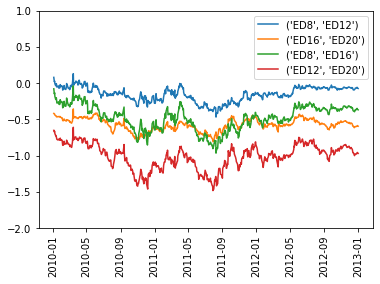

In [6]:
for n in combinations:
    pairs = cointegration(df1,n[0],n[1])[0] 
    plt.plot(pairs, label=(n[0],n[1]))
    plt.ylim(-2,1)
    plt.xticks(rotation=90)
    plt.legend(loc=0)

### 2. Let's define $z(t,\lambda)$ as {cointegrated vector(t)-EMA(t,$\lambda$)}. Use sample B to construct the following signal models

### 6-month rolling window

In [7]:
dt_last="2015-01-01"
dates_2=pd.date_range(end = dt_last, periods = 5,freq = "6M")
for x,y,z in zip(range(1,5),range(0,4),range(1,5)):
    print("Window {}: {} to {}".format(x, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d')))

Window 1: 2012-12-31 to 2013-06-30
Window 2: 2013-06-30 to 2013-12-31
Window 3: 2013-12-31 to 2014-06-30
Window 4: 2014-06-30 to 2014-12-31


In [8]:
def signal(df, ed1, ed2, lmda, dt1, dt2, ndays):
    """ 
    Parameters
    ----------
    df -> Data frame
    ed1 -> 1st ED Future
    ed2 -> 2nd ED future
    lmda -> lambda
    dt1 -> First date of sample
    dt2 -> Last day of sample
    ndays -> Number of days forecasted
    
    Returns
    ----------
    (1) forecast, (2) forecast error, (3) predicted cointegrated pair (hat), (4) observed cointegrated pair,
    (5) signal, (6) predicted signal (hat)
    """ 
    
    data_set=df.loc[dt1:dt2,:]    
    pair, weights=cointegration(data_set,ed1,ed2)
    
    if lmda !=0:
        EMA=pd.Series(pair).ewm(alpha=lmda,adjust=True).mean()
    else:
        EMA=pair[0]
    
    sig=pair-EMA
    model = ARIMA(sig, order=(1,0,0))
    model_fit= model.fit(disp=0, solver= 'bfgs')
    
    initial_coint,initial_signal=([],[])
    forecast_coint,forecast_signal=([],[])
    
    sig_predictions=model_fit.predict()
    coint_pair_pred=sig_predictions+EMA
    fc= model_fit.forecast(ndays)[0]
    
    initial_signal.append(sig_predictions[-1]) 
    forecast_signal.append(fc)
    
    if lmda !=0:
        initial_coint.append(sig_predictions[-1]+EMA[-1])         
        forecast_coint.append(fc+EMA[-1]) 
    else:
        initial_coint.append(sig_predictions[-1]+EMA)      
        forecast_coint.append(fc+EMA) 

    #Agrupping the forecast into a data frame
    coint_today = pd.DataFrame(initial_coint).T
    coint_series = pd.DataFrame(forecast_coint).T
    forecast= coint_today.append(coint_series, ignore_index=True)
    forecast.columns=["Forecasted coint_pair"]
    
    sig_today = pd.DataFrame(initial_signal).T
    sig_series = pd.DataFrame(forecast_signal).T
    forecast["Forecasted signal"]= sig_today .append(sig_series, ignore_index=True)
    
    index=data_set.index
    df_test=df.loc[index[-1].strftime('%Y-%m-%d'):,:].index
    test_index=df_test[0:ndays+1].strftime('%Y-%m-%d')
    forecast.index=test_index
    
    #Forecast error
    data_new=df.loc[dt1:test_index[-1],:]    
    pair_2, weights=cointegration(data_new,ed1,ed2)
    
    if lmda !=0:
        EMA=pd.Series(pair_2).ewm(alpha=lmda,adjust=True).mean()
    else:
        EMA=pair_2[0]
    
    sig_2=pair_2-EMA
    
    pair_=pd.DataFrame(pair_2)
    oos_pair=pair_.loc[test_index[1]:test_index[-1],:]
    oos_pair.columns=["cointegrated pair out-of-sample"]
    
    sig_=pd.DataFrame(sig_2)
    oos_sig=sig_.loc[test_index[1]:test_index[-1],:]
    
    forecast_sig=forecast.iloc[1:,1]
    rmse=np.sqrt(mean_squared_error(oos_sig, forecast_sig))
    
    return forecast, rmse, coint_pair_pred, pair, oos_pair, sig, sig_predictions

### AR(1) model fitted to $z(t,\lambda=0)$

In [9]:
lmda_1=0
lmda_2=0.01
lmda_3=0.1
ndays=5

**The following results are the forecasted cointegrated pair and the forecasted signal for 5 days**

In [10]:
import warnings
warnings.filterwarnings('ignore')
df2=df.loc["2013-01-01":"2015-01-10",:] #I included 10 days more just to get the date index and include it in my forecast. 

error=[]
for x,y,z in zip(range(1,5),range(0,4),range(1,5)):
    print("Window {}: {} to {}".format(x, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d')))    
    for n in combinations:
        signal1 = signal(df2, n[0],n[1], lmda_1, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d'),5)
        print("{}-{}, RMSE Signal:{}".format(n[0],n[1],round(signal1[1], 4)))
        print(signal1[0])
        print("==========================================") 
        error.append(signal1[1])

Window 1: 2012-12-31 to 2013-06-30
ED8-ED12, RMSE Signal:0.0249
            Forecasted coint_pair  Forecasted signal
2013-06-28               0.091091          -0.062903
2013-07-01               0.085475          -0.068518
2013-07-02               0.089080          -0.064914
2013-07-03               0.092337          -0.061656
2013-07-05               0.095281          -0.058713
2013-07-08               0.097941          -0.056052
ED16-ED20, RMSE Signal:0.0321
            Forecasted coint_pair  Forecasted signal
2013-06-28              -0.831649          -0.059822
2013-07-01              -0.841879          -0.070052
2013-07-02              -0.839693          -0.067867
2013-07-03              -0.837626          -0.065800
2013-07-05              -0.835672          -0.063845
2013-07-08              -0.833824          -0.061997
ED8-ED16, RMSE Signal:0.0238
            Forecasted coint_pair  Forecasted signal
2013-06-28              -0.050658          -0.071969
2013-07-01              -0.05

In [11]:
Error_Sig1=sum(error) / len(error) 
print("Average RMSE:{}".format(Error_Sig1))

Average RMSE:0.16189158358147368


### AR(1) model fitted to $z(t,\lambda=0.01)$

In [12]:
error=[]
for x,y,z in zip(range(1,5),range(0,4),range(1,5)):
    print("Window {}: {} to {}".format(x, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d')))    
    for n in combinations:
        signal2 = signal(df2, n[0],n[1], lmda_2, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d'),5)
        print("{}-{}, RMSE Signal:{}".format(n[0],n[1],round(signal2[1], 4)))
        print(signal2[0])
        print("==========================================") 
        error.append(signal2[1])

Window 1: 2012-12-31 to 2013-06-30
ED8-ED12, RMSE Signal:0.0244
            Forecasted coint_pair  Forecasted signal
2013-06-28               0.090124          -0.030285
2013-07-01               0.085200          -0.035209
2013-07-02               0.088430          -0.031978
2013-07-03               0.091241          -0.029168
2013-07-05               0.093686          -0.026723
2013-07-08               0.095813          -0.024595
ED16-ED20, RMSE Signal:0.037
            Forecasted coint_pair  Forecasted signal
2013-06-28              -0.832327          -0.034393
2013-07-01              -0.841903          -0.043969
2013-07-02              -0.839748          -0.041813
2013-07-03              -0.837716          -0.039782
2013-07-05              -0.835801          -0.037867
2013-07-08              -0.833996          -0.036062
ED8-ED16, RMSE Signal:0.0232
            Forecasted coint_pair  Forecasted signal
2013-06-28              -0.052122          -0.028818
2013-07-01              -0.057

In [13]:
Error_Sig2=sum(error) / len(error) 
print("Average RMSE:{}".format(Error_Sig2))

Average RMSE:0.16194027309375272


### AR(1) model fitted to $z(t,\lambda=0.1)$

In [14]:
error=[]
for x,y,z in zip(range(1,5),range(0,4),range(1,5)):
    print("Window {}: {} to {}".format(x, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d')))    
    for n in combinations:
        signal3 = signal(df2, n[0],n[1], lmda_3, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d'),5)
        print("{}-{}, RMSE Signal:{} \n".format(n[0],n[1],round(signal3[1], 4)))
        print(signal3[0])
        print("==========================================") 
        error.append(signal3[1])

Window 1: 2012-12-31 to 2013-06-30
ED8-ED12, RMSE Signal:0.0187 

            Forecasted coint_pair  Forecasted signal
2013-06-28               0.089809          -0.032629
2013-07-01               0.088451          -0.033987
2013-07-02               0.094136          -0.028302
2013-07-03               0.098775          -0.023663
2013-07-05               0.102562          -0.019876
2013-07-08               0.105653          -0.016785
ED16-ED20, RMSE Signal:0.037 

            Forecasted coint_pair  Forecasted signal
2013-06-28              -0.834651          -0.025460
2013-07-01              -0.840821          -0.031630
2013-07-02              -0.837822          -0.028631
2013-07-03              -0.835151          -0.025960
2013-07-05              -0.832773          -0.023582
2013-07-08              -0.830655          -0.021464
ED8-ED16, RMSE Signal:0.0181 

            Forecasted coint_pair  Forecasted signal
2013-06-28              -0.051692          -0.032544
2013-07-01              

In [15]:
Error_Sig3=sum(error) / len(error) 
print("Average RMSE:{}".format(Error_Sig3))

Average RMSE:0.09493063255010849


### 3. Signal 4

**I constructed signal 4 by regressing the predicted cointegrated pairs against the actual cointegrated pair. The weights are the normalized coefficients from the regression. Signal 4 is the weighted signal of signal 1,2 & 3.**

In [16]:
def signal4(pair_pred1,pair_pred2,pair_pred3, actual_pair):
    """ 
    Parameters
    ----------
    pair_pred1 -> Predicted cointegrater pair (i.e. lambda=0)
    pair_pred2 -> Predicted cointegrater pair (i.e. lambda=0.01)
    pair_pred3 -> Predicted cointegrater pair (i.e. lambda=0.1)
    actual_pair -> cointegrated vector
    
    Returns
    ----------
    (1) normalized weights for each signal, (2) weighted signal (signal 1,2 & 3 combined)
    """ 
    
    pair=pd.DataFrame({"actual_pair": actual_pair})
    pair_pred=pd.DataFrame({"pair_pred1":pair_pred1,"pair_pred2":pair_pred2,"pair_pred3":pair_pred3})
    n = len(pair_pred.columns)
    
    X = pair_pred.values
    Y = pair.values
    reg= sm.OLS(Y,X).fit()
    B=reg.params[0:(n+1)]
    
    score = np.argsort(B)
    w=B[score]
    weights=[B[0]/w[2],B[1]/w[2],B[2]/w[2]]
    
    signal=weights[0]*pair_pred1+weights[1]*pair_pred2+weights[2]*pair_pred3  
    
    return weights,signal

In [17]:
print("Strategy 4, weights for Signal 1, Signal 2 and Signal 3")
for x,y,z in zip(range(1,5),range(0,4),range(1,5)):
    print("Window {}: {} to {}".format(x, dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d')))    
    for n in combinations:
        signal1 = signal(df2, n[0],n[1], lmda_1,  dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d'),ndays)
        signal2= signal(df2, n[0],n[1], lmda_2,  dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d'),ndays)
        signal3= signal(df2, n[0],n[1], lmda_3,  dates_2[y].strftime('%Y-%m-%d'), dates_2[z].strftime('%Y-%m-%d'),ndays)
        print("{}-{}".format(n[0],n[1]))
        weights=signal4(signal1[2],signal2[2],signal3[2], signal1[3])
        print(weights[0])
        print("==========================================") 

Strategy 4, weights for Signal 1, Signal 2 and Signal 3
Window 1: 2012-12-31 to 2013-06-30
ED8-ED12
[0.06389851699397778, -0.7994813463603486, 1.0]
ED16-ED20
[0.07908834679000992, -0.9230644231210097, 1.0]
ED8-ED16
[0.03393735916032273, -0.8724568031307801, 1.0]
ED12-ED20
[0.08571155365526276, -0.9180666432107323, 1.0]
Window 2: 2013-06-30 to 2013-12-31
ED8-ED12
[-0.1781638457102588, -0.6518031986849708, 1.0]
ED16-ED20
[0.01992934502909001, -0.7961707334126773, 1.0]
ED8-ED16
[-0.09205114151878592, -0.6828208454334117, 1.0]
ED12-ED20
[0.017800492690036272, -0.7982240334715862, 1.0]
Window 3: 2013-12-31 to 2014-06-30
ED8-ED12
[0.3499028715462038, -1.0751335833582591, 1.0]
ED16-ED20
[0.2182173978292584, -0.9864616337930271, 1.0]
ED8-ED16
[0.14716688581722098, -0.8674260943642907, 1.0]
ED12-ED20
[0.11852680930575138, -0.6589340817445838, 1.0]
Window 4: 2014-06-30 to 2014-12-31
ED8-ED12
[0.06028270207450742, -0.8237862948401813, 1.0]
ED16-ED20
[0.012809222887276078, -0.803137527924024, 1.0]

### 4. Define a set of signal quality metrics, and explain clearly what you are implementing.

### 4.1.1 Correlation between the forecast for the H-day change in the cointegrated vector and realized change over H days 

**The first step to compute the correlation is to find the forecast for the cointegrated vectors and the realized change. The function "Signal" returns both vectors. Then we have to calculate the daily returns, and finally we calculate the correlation between both vectors.**

In [18]:
#Example data to get the correlation between "Forecasted coint_pair" and the "cointegrated pair out-of-sample"
signal_ = signal(df, "ED8","ED12", lmda_1, "2014-01-01","2015-01-01",ndays)
print(signal_[0].iloc[1:,:])
print(signal_[4])

            Forecasted coint_pair  Forecasted signal
2015-01-02              -6.699905           0.357640
2015-01-05              -6.761781           0.295764
2015-01-06              -6.811120           0.246425
2015-01-07              -6.850463           0.207082
2015-01-08              -6.881835           0.175710
            cointegrated pair out-of-sample
Date                                       
2015-01-02                        -9.010974
2015-01-05                        -8.679806
2015-01-06                        -8.232736
2015-01-07                        -8.190753
2015-01-08                        -8.377015


In [19]:
def correlation(df, lmda, d1, d2,ndays):
    corr_=[]
    combinations=[("ED8","ED12"),("ED16","ED20"),("ED8","ED16"),("ED12","ED20")]
    print("Date: {} to {}".format(d1, d2))    
    for n in combinations:
        signal_ = signal(df, n[0],n[1], lmda, d1, d2,ndays)
        print("{}-{}".format(n[0],n[1]))
        fct=signal_[0].iloc[1:,0].diff(1).dropna()
        act=signal_[4].diff(1).dropna()
        corr=act.corrwith(fct).values
        corr_.append(corr[0])
        print("Correlation:{}".format(corr[0]))
        print("==========================================")

    corr_Sig1=[ abs(x) for x in corr_]
    Sig1=sum(corr_Sig1) / len(corr_Sig1) 
    print("Average absolute correlation:{}".format(Sig1))

In [20]:
dates=["2014-01-01","2015-01-01"]

### Signal 1, $z(t,\lambda=0)$

In [21]:
corr_signal1=correlation(df2, lmda_1, dates[0], dates[1],ndays)

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Correlation:-0.8425278478859662
ED16-ED20
Correlation:0.3566464276077076
ED8-ED16
Correlation:-0.8231847633661289
ED12-ED20
Correlation:-0.9115160050155021
Average absolute correlation:0.7334687609688262


### Signal 2,  $z(t,\lambda=0.01)$

In [22]:
corr_signal2=correlation(df2, lmda_2, dates[0], dates[1],ndays)

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Correlation:-0.8398353587036791
ED16-ED20
Correlation:-0.21335504621037027
ED8-ED16
Correlation:-0.8215048931105132
ED12-ED20
Correlation:-0.8724419046495875
Average absolute correlation:0.6867843006685375


### Signal 3, $z(t,\lambda=0.1)$

In [23]:
corr_signal3=correlation(df2, lmda_3, dates[0], dates[1],ndays)

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Correlation:-0.8090995797312849
ED16-ED20
Correlation:-0.1388224175381938
ED8-ED16
Correlation:-0.7882380118958106
ED12-ED20
Correlation:-0.8219802128348199
Average absolute correlation:0.6395350555000273


### Signal 4

**I followed the same steps as before, the only difference here is that I'm calculating the weights to build the signal 4 for each spread. Then I multiplied each forecast by their corresponding weight (i.e., forecast of signal 1 by weight of signal 1), and finally, I calculated the correlation between the signal 4 and the weighted forecast.**

In [24]:
corr_=[]
combinations=[("ED8","ED12"),("ED16","ED20"),("ED8","ED16"),("ED12","ED20")]
print("Date: {} to {}".format(dates[0], dates[1]))    
for n in combinations:
    signal1 = signal(df2, n[0],n[1], lmda_1, dates[0], dates[1],ndays)
    signal2 = signal(df2, n[0],n[1], lmda_2, dates[0], dates[1],ndays)
    signal3 = signal(df2, n[0],n[1], lmda_3, dates[0], dates[1],ndays)
    weights=signal4(signal1[2],signal2[2],signal3[2], signal1[3])
    print("{}-{}".format(n[0],n[1]))
    fct=(signal1[0].iloc[1:,0]*weights[0][0]+signal2[0].iloc[1:,0]*weights[0][1] +signal3[0].iloc[1:,0]*weights[0][2]).diff(1).dropna()
    act=signal1[4].diff(1).dropna()
    corr=act.corrwith(fct).values
    corr_.append(corr[0])
    print("Correlation:{}".format(corr[0]))
    print("==========================================")

corr_Sig4=[ abs(x) for x in corr_]
Sig4=sum(corr_Sig4) / len(corr_Sig4) 
print("Average absolute correlation:{}".format(Sig4))

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Correlation:0.8995383873709316
ED16-ED20
Correlation:0.2962726043000995
ED8-ED16
Correlation:0.8609000345702145
ED12-ED20
Correlation:0.8946830493848562
Average absolute correlation:0.7378485189065255


### 4.1.2 Hit Ratio

**To compute the hit ratio I used the observed signal and the predicted signal, then I found the number of times the sign of the daily return match between both vectors, and finally I divided by the total of positives/negatives of the signal vector.**

In [25]:
#Example data to get the hit-ratio
signal_ = signal(df, "ED8","ED12", lmda_1, "2014-01-01","2015-01-01",ndays)
print("Signal")
print(signal_[5])
print("=====================")
print("Predicted signal")
print(signal_[6])

Signal
Date
2014-01-02    0.000000
2014-01-03   -0.027829
2014-01-06    0.096762
2014-01-07    0.166181
2014-01-08   -0.232352
                ...   
2014-12-24    0.111653
2014-12-26    0.102736
2014-12-29    0.278797
2014-12-30    0.345895
2014-12-31    0.435238
Length: 240, dtype: float64
Predicted signal
Date
2014-01-02    0.052244
2014-01-03    0.010585
2014-01-06   -0.011606
2014-01-07    0.087742
2014-01-08    0.143097
                ...   
2014-12-24    0.085484
2014-12-26    0.099616
2014-12-29    0.092506
2014-12-30    0.232896
2014-12-31    0.286399
Length: 240, dtype: float64


In [26]:
def hit_ratio(df, lmda, d1, d2,ndays):
    long_=[]
    short_=[]
    combinations=[("ED8","ED12"),("ED16","ED20"),("ED8","ED16"),("ED12","ED20")]
    
    print("Date: {} to {}".format(d1, d2))    
    for n in combinations:
        signal_= signal(df, n[0],n[1], lmda, d1, d2,5 )
        print("{}-{}".format(n[0],n[1]))
        df_sig=pd.DataFrame({"Signal":signal_[5], "Signal_Pred":signal_[6]}).diff(1).dropna()
        long=len(df_sig.loc[(df_sig.Signal> 0) & (df_sig.Signal_Pred >0)])/len(df_sig.loc[df_sig.Signal> 0])
        short=len(df_sig.loc[(df_sig.Signal< 0) & (df_sig.Signal_Pred < 0)])/len(df_sig.loc[df_sig.Signal< 0])
        print("Hit-ratio (Long):{}".format(long))
        print("Hit-ratio (Short):{}".format(short))
        print("==========================================")
        long_.append(long)
        short_.append(short)

    Sig_long=sum(long_) / len(long_) 
    Sig_short=sum(short_) / len(short_)
    print("Average hit-ratio (long):{}".format(Sig_long))
    print("Average hit-ratio (short):{}".format(Sig_short))
    summ=Sig_long+Sig_short
    print(summ)

### Signal 1, $z(t,\lambda=0)$

In [27]:
hit_ratio1=hit_ratio(df2, lmda_1, dates[0], dates[1],ndays)

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Hit-ratio (Long):0.49572649572649574
Hit-ratio (Short):0.5245901639344263
ED16-ED20
Hit-ratio (Long):0.4444444444444444
Hit-ratio (Short):0.4672131147540984
ED8-ED16
Hit-ratio (Long):0.5294117647058824
Hit-ratio (Short):0.525
ED12-ED20
Hit-ratio (Long):0.5130434782608696
Hit-ratio (Short):0.5403225806451613
Average hit-ratio (long):0.4956565457844231
Average hit-ratio (short):0.5142814648334215
1.0099380106178446


### Signal 2, $z(t,\lambda=0.01)$

In [28]:
hit_ratio2=hit_ratio(df2, lmda_2, dates[0], dates[1],ndays)

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Hit-ratio (Long):0.4959349593495935
Hit-ratio (Short):0.46551724137931033
ED16-ED20
Hit-ratio (Long):0.45132743362831856
Hit-ratio (Short):0.5079365079365079
ED8-ED16
Hit-ratio (Long):0.5210084033613446
Hit-ratio (Short):0.5166666666666667
ED12-ED20
Hit-ratio (Long):0.5087719298245614
Hit-ratio (Short):0.544
Average hit-ratio (long):0.49426068154095454
Average hit-ratio (short):0.5085301039956213
1.0027907855365759


### Signal 3, $z(t,\lambda=0.1)$

In [29]:
hit_ratio3=hit_ratio(df2, lmda_3, dates[0], dates[1],ndays)

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Hit-ratio (Long):0.5039370078740157
Hit-ratio (Short):0.44642857142857145
ED16-ED20
Hit-ratio (Long):0.44642857142857145
Hit-ratio (Short):0.5118110236220472
ED8-ED16
Hit-ratio (Long):0.45045045045045046
Hit-ratio (Short):0.515625
ED12-ED20
Hit-ratio (Long):0.4608695652173913
Hit-ratio (Short):0.49193548387096775
Average hit-ratio (long):0.46542139874260724
Average hit-ratio (short):0.4914500197303966
0.9568714184730038


### Signal 4

In [30]:
long_=[]
short_=[]
print("Date: {} to {}".format(dates[0], dates[1]))    
for n in combinations:
    signal1 = signal(df2, n[0],n[1], lmda_1, dates[0], dates[1],ndays)
    signal2 = signal(df2, n[0],n[1], lmda_2, dates[0], dates[1],ndays)
    signal3 = signal(df2, n[0],n[1], lmda_3, dates[0], dates[1],ndays)
    weights=signal4(signal1[2],signal2[2],signal3[2], signal1[3])
    print("{}-{}".format(n[0],n[1]))
    sig_pred=(signal1[6]*weights[0][0]+signal2[6]*weights[0][1] +signal3[6]*weights[0][2])
    df_sig=pd.DataFrame({"Signal":weights[1], "Signal_Pred":sig_pred}).diff(1).dropna()
    long=len(df_sig.loc[(df_sig.Signal> 0) & (df_sig.Signal_Pred >0)])/len(df_sig.loc[df_sig.Signal> 0])
    short=len(df_sig.loc[(df_sig.Signal< 0) & (df_sig.Signal_Pred < 0)])/len(df_sig.loc[df_sig.Signal< 0])
    print("Hit-ratio (Long):{}".format(long))
    print("Hit-ratio (Short):{}".format(short))
    print("==========================================")
    long_.append(long)
    short_.append(short)

Sig_long=sum(long_) / len(long_) 
Sig_short=sum(short_) / len(short_)
print("Average hit-ratio (long):{}".format(Sig_long))
print("Average hit-ratio (short):{}".format(Sig_short))
summ=Sig_long+Sig_short
print(summ)

Date: 2014-01-01 to 2015-01-01
ED8-ED12
Hit-ratio (Long):0.6363636363636364
Hit-ratio (Short):0.6610169491525424
ED16-ED20
Hit-ratio (Long):0.496551724137931
Hit-ratio (Short):0.4148936170212766
ED8-ED16
Hit-ratio (Long):0.6666666666666666
Hit-ratio (Short):0.6721311475409836
ED12-ED20
Hit-ratio (Long):0.6893203883495146
Hit-ratio (Short):0.6985294117647058
Average hit-ratio (long):0.6222256038794372
Average hit-ratio (short):0.611642781369877
1.2338683852493142


### 4.2 Apply signal quality metrics to Signals 1-3 (or Signals 1-4) in Sample C

### 4.2.1 Correlation between the forecast for the H-day change in the cointegrated vector and realized change over H days 

In [31]:
df3=df.loc["2015-01-01":"2017-01-10",:] #I included 10 days more just to get the date index and include it in my forecast
dates=["2015-01-01","2017-01-01"]

### Signal 1, $z(t,\lambda=0)$

In [32]:
corr_signal1=correlation(df3, lmda_1, dates[0], dates[1],ndays)

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Correlation:0.10871515530754437
ED16-ED20
Correlation:0.3890902171586795
ED8-ED16
Correlation:0.17239513341425966
ED12-ED20
Correlation:0.3126804618670332
Average absolute correlation:0.2457202419368792


### Signal 2, $z(t,\lambda=0.01)$

In [33]:
corr_signal2=correlation(df3, lmda_2, dates[0], dates[1],ndays)

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Correlation:0.1082890496543892
ED16-ED20
Correlation:0.3904533990137203
ED8-ED16
Correlation:0.1720594830570484
ED12-ED20
Correlation:0.31267303080393555
Average absolute correlation:0.24586874063227337


### Signal 3, $z(t,\lambda=0.1)$

In [34]:
corr_signal3=correlation(df3, lmda_3, dates[0], dates[1],ndays)

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Correlation:0.10374634620541433
ED16-ED20
Correlation:0.39865284415159263
ED8-ED16
Correlation:0.16808198897632817
ED12-ED20
Correlation:0.31168124158092325
Average absolute correlation:0.2455406052285646


### Signal 4

In [35]:
corr_=[]
print("Date: {} to {}".format(dates[0], dates[1]))    
for n in combinations:
    signal1 = signal(df3, n[0],n[1], lmda_1, dates[0], dates[1],ndays)
    signal2 = signal(df3, n[0],n[1], lmda_2, dates[0], dates[1],ndays)
    signal3 = signal(df3, n[0],n[1], lmda_3, dates[0], dates[1],ndays)
    weights=signal4(signal1[2],signal2[2],signal3[2], signal1[3])
    print("{}-{}".format(n[0],n[1]))
    fct=(signal1[0].iloc[1:,0]*weights[0][0]+signal2[0].iloc[1:,0]*weights[0][1] +signal3[0].iloc[1:,0]*weights[0][2]).diff(1).dropna()
    act=signal1[4].diff(1).dropna()
    corr=act.corrwith(fct).values
    corr_.append(corr[0])
    print("Correlation:{}".format(corr[0]))
    print("==========================================")

corr_Sig4=[ abs(x) for x in corr_]
Sig4=sum(corr_Sig4) / len(corr_Sig4) 
print("Average absolute correlation:{}".format(Sig4))

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Correlation:0.050277159050530214
ED16-ED20
Correlation:0.4190932918802606
ED8-ED16
Correlation:0.14602472535879907
ED12-ED20
Correlation:0.3068899784297866
Average absolute correlation:0.23057128867984414


### 4.2.2 Hit Ratio

In [36]:
hit_ratio1=hit_ratio(df3, lmda_1, dates[0], dates[1],ndays)

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Hit-ratio (Long):0.5461538461538461
Hit-ratio (Short):0.5102880658436214
ED16-ED20
Hit-ratio (Long):0.504
Hit-ratio (Short):0.5098814229249012
ED8-ED16
Hit-ratio (Long):0.5724907063197026
Hit-ratio (Short):0.5042735042735043
ED12-ED20
Hit-ratio (Long):0.5482625482625483
Hit-ratio (Short):0.5204918032786885
Average hit-ratio (long):0.5427267751840241
Average hit-ratio (short):0.5112336990801789
1.053960474264203


In [37]:
hit_ratio2=hit_ratio(df3, lmda_2, dates[0], dates[1],ndays)

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Hit-ratio (Long):0.5363984674329502
Hit-ratio (Short):0.5
ED16-ED20
Hit-ratio (Long):0.5215686274509804
Hit-ratio (Short):0.5080645161290323
ED8-ED16
Hit-ratio (Long):0.5405405405405406
Hit-ratio (Short):0.5122950819672131
ED12-ED20
Hit-ratio (Long):0.5363984674329502
Hit-ratio (Short):0.5041322314049587
Average hit-ratio (long):0.5337265257143553
Average hit-ratio (short):0.506122957375301
1.0398494830896563


In [38]:
hit_ratio3=hit_ratio(df3, lmda_3, dates[0], dates[1],ndays)

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Hit-ratio (Long):0.49206349206349204
Hit-ratio (Short):0.4900398406374502
ED16-ED20
Hit-ratio (Long):0.525691699604743
Hit-ratio (Short):0.524
ED8-ED16
Hit-ratio (Long):0.5158730158730159
Hit-ratio (Short):0.5139442231075697
ED12-ED20
Hit-ratio (Long):0.532319391634981
Hit-ratio (Short):0.49166666666666664
Average hit-ratio (long):0.516486899794058
Average hit-ratio (short):0.5049126826029217
1.0213995823969797


In [39]:
long_=[]
short_=[]
print("Date: {} to {}".format(dates[0], dates[1]))    
for n in combinations:
    signal1 = signal(df3, n[0],n[1], lmda_1, dates[0], dates[1],ndays)
    signal2 = signal(df3, n[0],n[1], lmda_2, dates[0], dates[1],ndays)
    signal3 = signal(df3, n[0],n[1], lmda_3, dates[0], dates[1],ndays)
    weights=signal4(signal1[2],signal2[2],signal3[2], signal1[3])
    print("{}-{}".format(n[0],n[1]))
    sig_pred=(signal1[6]*weights[0][0]+signal2[6]*weights[0][1] +signal3[6]*weights[0][2])
    df_sig=pd.DataFrame({"Signal":weights[1], "Signal_Pred":sig_pred}).diff(1).dropna()
    long=len(df_sig.loc[(df_sig.Signal> 0) & (df_sig.Signal_Pred >0)])/len(df_sig.loc[df_sig.Signal> 0])
    short=len(df_sig.loc[(df_sig.Signal< 0) & (df_sig.Signal_Pred < 0)])/len(df_sig.loc[df_sig.Signal< 0])
    print("Hit-ratio (Long):{}".format(long))
    print("Hit-ratio (Short):{}".format(short))
    print("==========================================")
    long_.append(long)
    short_.append(short)

Sig_long=sum(long_) / len(long_) 
Sig_short=sum(short_) / len(short_)
print("Average hit-ratio (long):{}".format(Sig_long))
print("Average hit-ratio (short):{}".format(Sig_short))
summ=Sig_long+Sig_short
print(summ)

Date: 2015-01-01 to 2017-01-01
ED8-ED12
Hit-ratio (Long):0.3886792452830189
Hit-ratio (Short):0.47478991596638653
ED16-ED20
Hit-ratio (Long):0.4063745019920319
Hit-ratio (Short):0.45634920634920634
ED8-ED16
Hit-ratio (Long):0.38697318007662834
Hit-ratio (Short):0.4834710743801653
ED12-ED20
Hit-ratio (Long):0.43529411764705883
Hit-ratio (Short):0.4959677419354839
Average hit-ratio (long):0.40433026124968446
Average hit-ratio (short):0.4776444846578105
0.8819747459074949


### 4.3 Compare and analyze your results across signals & samples

#### (1) Signal quality metric: correlation

- **Sample b**: overall, signal 4 has the highest correlation among the set of signals.The second-best is signal 1 or $\lambda=0.0$. Among all the set of correlations, the correlation for the spread ED16-ED20 is the smallest, and ED8-ED12 is the greatest.
      
- **Sample c**: when $\lambda=0.01$ the correlation is the highest, the second-best is $\lambda=0$. Among all the sets of correlations, the correlation for the spread ED8-ED12 is the smallest, and ED16-ED20 is the greatest.

#### (2) Signal quality metric: hit-ratio

- **Sample b**: overall, signal 4 has the highest hit-ratio among the set of signals.The second-best is signal 1 or $\lambda=0.0$. Among all the set of hit-ratios, the hit-ratio for the spread ED16-ED20 is the smallest. These results validate the results obtained from the first quality metric.
      
- **Sample c**: signal 1 or $\lambda=0.0$  has the highest hit-ratio among the set of spreads, the second-best is $\lambda=0.01$. Note that the hit ratio among the set of spread remains homogeneous.